In [76]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import pandas as pd

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import nibabel as nib

from brainiak.isc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io

import matplotlib.pyplot as plt
import pdb
%autosave 5
%matplotlib inline

Autosaving every 5 seconds


In [77]:
#set directories
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'
exp_dir= f'ginn/fmri/hbn'
study_dir = f'/lab_data/behrmannlab/scratch/vlad/{exp_dir}'
subj_dir=f'{study_dir}/derivatives/preprocessed_data'
out_dir = f'{study_dir}/derivatives/mean_func'
results_dir =f'{curr_dir}/results/mvpd'
roi_dir = f'{study_dir}/derivatives/rois'

age = 18

In [78]:
curr_subs = pd.read_csv(f'{curr_dir}/fmri/HBN-Site-CBIC.csv')

def get_existing_files(curr_subs):
    
    sub_file =pd.DataFrame(columns=['sub','age'])
    for sub in enumerate(curr_subs['participant_id']):
        img = f'{subj_dir}/sub-{sub[1]}/sub-{sub[1]}_task-movieDM_bold.nii.gz'
        
        if os.path.exists(img):
            
            
            sub_file = sub_file.append(pd.Series([sub[1], curr_subs['Age'][sub[0]]], index = sub_file.columns), ignore_index = True)

    return sub_file

curr_subs = get_existing_files(curr_subs)
curr_subs = curr_subs[curr_subs['age']>=18]
curr_subs = curr_subs.drop_duplicates(subset ="sub",)
curr_subs = curr_subs.reset_index()


In [79]:
'''
load subs into numpy array
'''
lr ='r'
roi = 'LO'

n = 0
all_data = []
for sub in curr_subs['sub']:
    
    
    sub_ts = np.load(f'{subj_dir}/sub-{sub}/timeseries/{lr}{roi}_ts_all.npy')
    sub_ts = np.transpose(sub_ts)
    sub_ts = np.expand_dims(sub_ts,axis =2)
    #all_data.append(sub_ts)
    #sub_ts = np.reshape(sub_ts, [sub_ts.shape[1], sub_ts.shape[0], sub_ts.shape[2]])
    #pdb.set_trace()
    
    if n == 0:
        all_data = sub_ts
        
        n += 1
    else:
        try:    
            all_data = np.concatenate((all_data,sub_ts), axis = 2)
        except:
            continue
     
    

In [80]:
all_data.shape

(5081, 750, 22)

In [81]:
train_data = []
test_data = []
for sub in range(0,all_data.shape[2]):
    # Take the first half of TRs as training
    # *The double dash means integer division
    train_data.append(all_data[:, :all_data.shape[1]//2, sub])
    
    # Take the second half of TRs as testing
    test_data.append(all_data[:, -(all_data.shape[1]//2):, sub])  

In [82]:
# Iterate through the subjects
for sub in range(0,all_data.shape[2]):    
    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

In [83]:
features = 50  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


SRM: Features X Time-points  (5, 375)


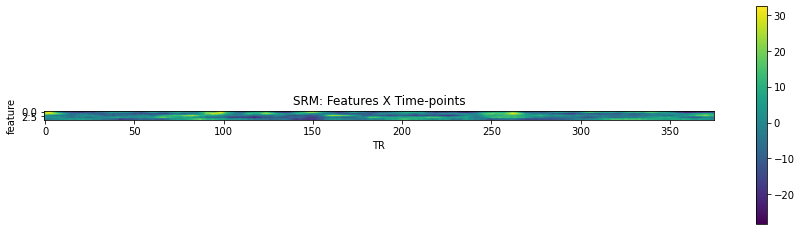

In [84]:
# Plot the shared response
print('SRM: Features X Time-points ', srm.s_.shape)
plt.figure(figsize=(15, 4))
plt.title('SRM: Features X Time-points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.s_, cmap='viridis')
plt.colorbar()

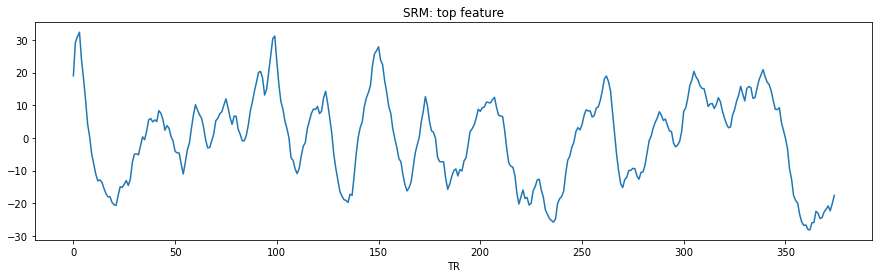

In [85]:
plt.figure(figsize=(15, 4))
plt.title('SRM: top feature')
plt.xlabel('TR')
plt.plot(srm.s_[0, :]);

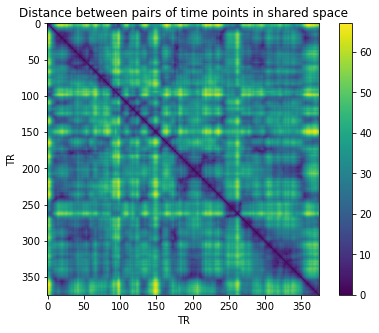

In [86]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure(figsize=(7,5))
plt.title('Distance between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()

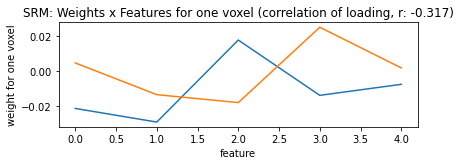

In [88]:
plt.subplot(211)

plt.plot(srm.w_[0][0,:])
plt.plot(srm.w_[1][0,:])
feature_corr = np.corrcoef(srm.w_[0][0,:], srm.w_[1][0,:].T)[0,1]
plt.title('SRM: Weights x Features for one voxel (correlation of loading, r: %0.3f)' % feature_corr) 
plt.xlabel('feature')
plt.ylabel('weight for one voxel')
plt.tight_layout()

In [89]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

# Zscore the transformed training data
for subject in range(0, all_data.shape[2]):
    shared_train[subject] = stats.zscore(shared_train[subject], axis=1, ddof=1)

In [90]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((train_data[0].shape[0], train_data[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    raw_obj[:, :, ppt] = train_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = isc(raw_obj, summary_statistic='mean')
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_train[0].shape[0], shared_train[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    shared_obj[:, :, ppt] = shared_train[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 66.50191214155166 p: 2.99619174e-316


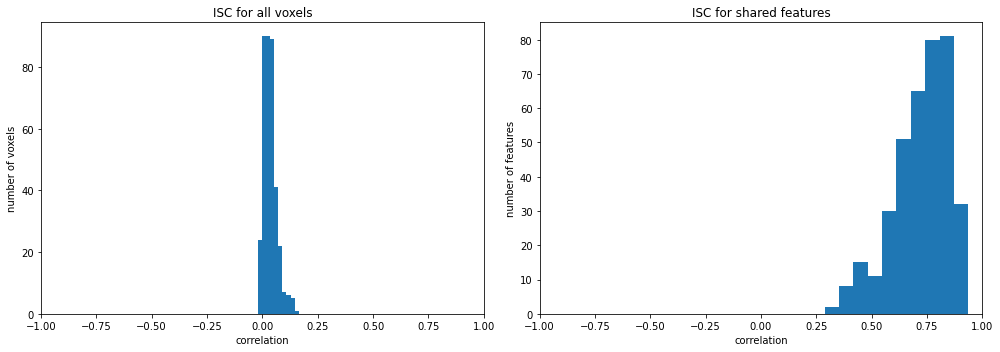

In [91]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1])

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

In [92]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Zscore the transformed test data
for subject in range(0, all_data.shape[2]):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

In [93]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((test_data[0].shape[0], test_data[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    raw_obj[:, :, ppt] = test_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = isc(raw_obj, summary_statistic='mean')
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    shared_obj[:, :, ppt] = shared_test[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_obj, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 24.129061368854696 p: 1.368885870147588e-95


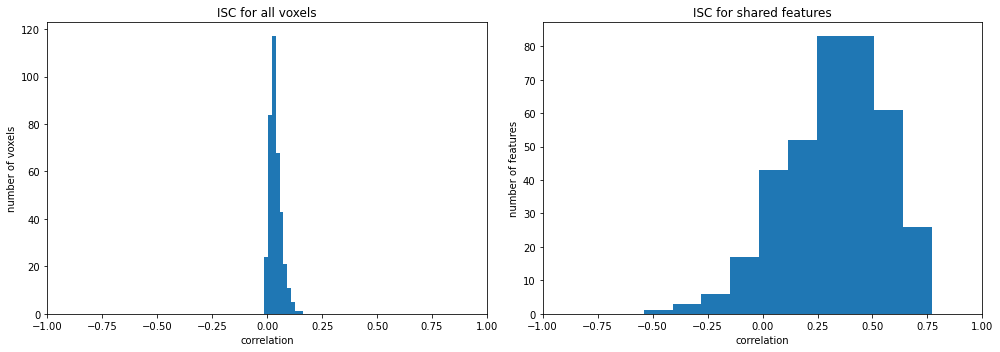

In [94]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('ISC for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('ISC for shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1])

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

In [95]:
# Transform subject-space test data into shared space
test_shared = srm.transform(test_data)

# z-score the transformed test data
test_shared = [stats.zscore(ts, axis=1) for ts in test_shared]

In [96]:
def time_segment_classification(data, win_size=10): 
    n_subjects = len(data)
    (n_features, n_trs) = data[0].shape
    accuracy = np.zeros(shape=n_subjects)
    n_segments = n_trs - win_size + 1
    
    # Set up container for training data
    train_data = np.zeros((n_features * win_size, n_segments), order='f')
    
    # Training data (includes test data, but will be removed)
    for m in range(n_subjects):
        for w in range(win_size):
            train_data[w * n_features:(w + 1) * n_features, :] += \
                data[m][:, w:(w + n_segments)]
            
    # Analyze each subject (leave-one-out)
    print("Between-subject time-segment classification accuracy "
          "for each subject:", end=' ')
    for test_subject in range(n_subjects):
        test_data = np.zeros((n_features * win_size, n_segments), order='f')
        for w in range(win_size):
            test_data[w * n_features:(w + 1) * n_features, :] = \
                data[test_subject][:, w:(w + n_segments)]

        A = np.nan_to_num(stats.zscore((train_data - test_data), axis=0))
        B = np.nan_to_num(stats.zscore(test_data, axis=0))

        # Compute correlation matrix
        correlations = compute_correlation(B.T, A.T)

        # Correlation-based classification
        for i in range(n_segments):
            for j in range(n_segments):
                
                # Exclude segments overlapping with the testing segment
                if abs(i - j) < win_size and i != j:
                    correlations[i, j] = -np.inf

        max_idx =  np.argmax(correlations, axis=1)
        accuracy[test_subject] = sum(max_idx == range(n_segments)) / n_segments

        # Print accuracy for each subject as we go
        print(f"{accuracy[test_subject]:.3f}",
              end=', ', flush=True)
        
    # Get a rough estimate of chance (accounting for excluded segments)
    chance = 1 / np.sum(~np.isinf(correlations[n_trs // 2]))
        
    print("\nThe average accuracy among all subjects is "
          f"{np.mean(accuracy):.3f} +/- {np.std(accuracy):.3f}")
    return accuracy, chance

In [97]:
# Time-segment classification on anatomically-aligned data
win_size = 10
acc_anat_test, chance = time_segment_classification(test_data, win_size=win_size)

Between-subject time-segment classification accuracy for each subject: 0.096, 0.107, 0.191, 0.063, 0.036, 0.077, 0.186, 0.068, 0.044, 0.038, 0.139, 0.139, 0.164, 0.000, 0.101, 0.235, 0.036, 0.011, 0.257, 0.153, 0.178, 0.049, 
The average accuracy among all subjects is 0.108 +/- 0.071


In [98]:
# Time-segment classification on SRM data
acc_shared_test, chance = time_segment_classification(test_shared, win_size=win_size)

Between-subject time-segment classification accuracy for each subject: 0.063, 0.038, 0.216, 0.093, 0.131, 0.019, 0.104, 0.068, 0.016, 0.049, 0.000, 0.052, 0.189, 0.005, 0.117, 0.385, 0.085, 0.003, 0.077, 0.142, 0.087, 0.022, 
The average accuracy among all subjects is 0.089 +/- 0.086


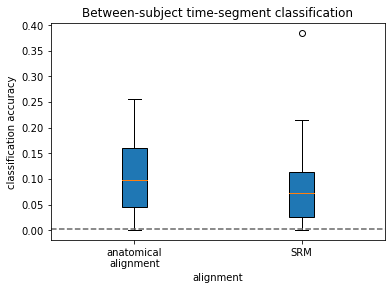

SRM functional alignment provides a marked improvement in between-
subject time-segment classification over anatomical alignment.
The dotted line indicates chance performance (chance = 0.003)


In [99]:
# Box plot for the classification results
labels = ['anatomical\nalignment', 'SRM']

plt.figure()
plt.boxplot([acc_anat_test, acc_shared_test], vert=True,
            patch_artist=True, labels=labels)
plt.axhline(chance, linestyle='--', color='.4')
plt.xlabel('alignment')
plt.ylabel('classification accuracy')
plt.title('Between-subject time-segment classification')
plt.show()

print("SRM functional alignment provides a marked improvement in "
      "between-\nsubject time-segment classification over "
      "anatomical alignment.\nThe dotted line indicates chance "
      f"performance (chance = {chance:.3f})")